In [99]:
import numpy as np
import pandas as pd
from navec import Navec
import matplotlib.pyplot as plt

train_df = pd.read_pickle("datasets/train_dataset.pickle")
navec = Navec.load("embedding.tar")

In [74]:
notnan_mask = train_df.iloc[:, 4:].notna().any(axis=1)
words_X = train_df[notnan_mask].iloc[:, 1:4].aggregate(lambda a: " ".join(a), axis=1).values
Y_cat = train_df[notnan_mask].iloc[:, 4:].notna()
Y_reg = train_df[notnan_mask].iloc[:, 4:].values

seq_len = max([len(text.split(" ")) for text in words_X]) + 1
X = np.zeros((len(words_X), seq_len, 300))
for i in range(len(X)):
    words = words_X[i].split(" ")
    unknown = navec['<unk>']
    pad = navec['<pad>']
    for j in range(len(words)):
        vector = navec.get(words[j])
        if vector is not None:
            X[i][j] = vector
        else:
            X[i][j] = unknown
    for j in range(len(words), seq_len):
        X[i][j] = pad

In [78]:
def target_split(Y, train_rate=0.8):
    train_Y = np.full_like(Y, np.nan)
    test_Y = np.full_like(Y, np.nan)
    for i in range(Y.shape[-1]):
        column_Y = Y[:, i]
        indexes = np.arange(len(column_Y))
        np.random.shuffle(indexes)
        train_indexes, test_indexes = indexes[:int(len(Y)*train_rate)], indexes[int(len(Y)*train_rate):]
        train_Y[:, i][train_indexes] = column_Y[train_indexes]
        test_Y [:, i][test_indexes]  = column_Y[test_indexes]

    return train_Y, test_Y

Y_train, Y_test = target_split(Y_reg) 

In [88]:
from keras.models import Sequential, Model
from keras.layers import Input, LSTM, Dense
from keras.losses import BinaryCrossentropy
import keras.backend as K
import tensorflow as tf
from sklearn.metrics import r2_score

def mse_nan(y_true, y_pred):
    index = ~tf.is_nan(y_true)
    y_true = tf.boolean_mask(y_true, index)
    y_pred = tf.boolean_mask(y_pred, index)
    return K.mean((y_true - y_pred) ** 2)

def mae_nan(y_true, y_pred):
    index = ~tf.is_nan(y_true)
    y_true = tf.boolean_mask(y_true, index)
    y_pred = tf.boolean_mask(y_pred, index)
    return K.abs(y_true - y_pred)

def r2_nan(y_true, y_pred):
    mask = Y[:, 37:] == Y[:, 37:]
    return r2_score(y_true[mask], y_pred[mask])

def score_model():
    inp = Input((seq_len,300))
    x = LSTM(30)(inp)
    
    # cat_pred = Dense(37, activation='sigmoid', name='cat')(x)
    reg_pred = Dense(37, name='reg')(x)

    model = Model(inp, reg_pred)
    model.compile(optimizer='adam', loss=mse_nan)
    return model

model = score_model()

In [89]:
model.fit(X, Y_train, epochs=200)

Epoch 1/200
159/159 [==============================] - 4s 28ms/step - loss: 1.6198
Epoch 2/200
159/159 [==============================] - 3s 20ms/step - loss: 1.6054
Epoch 3/200
159/159 [==============================] - 4s 23ms/step - loss: 1.5445
Epoch 4/200
159/159 [==============================] - 3s 20ms/step - loss: 1.5011
Epoch 5/200
159/159 [==============================] - 3s 20ms/step - loss: 1.2837
Epoch 6/200
159/159 [==============================] - 3s 22ms/step - loss: 0.9098
Epoch 7/200
159/159 [==============================] - 4s 23ms/step - loss: 0.6677
Epoch 8/200
159/159 [==============================] - 3s 22ms/step - loss: 0.5466
Epoch 9/200
159/159 [==============================] - 3s 22ms/step - loss: 0.4644
Epoch 10/200
159/159 [==============================] - 3s 22ms/step - loss: 0.3984
Epoch 11/200
159/159 [==============================] - 3s 22ms/step - loss: 0.3668
Epoch 12/200
159/159 [==============================] - 3s 22ms/step - loss: 0.3382
E

In [149]:
def reg_accuracy(y_true, y_pred, range):
    mask = y_true == y_true
    y_true = y_true[mask]
    y_pred = y_pred[mask]
    correct = 0
    for t, p in zip(y_true, y_pred):
        if abs(t - p) <= range:
            correct += 1
    return correct / len(y_true)

pred_reg = model.predict(X)
mask = Y_test == Y_test
print("Reg r2:", r2_score(Y_test[mask], pred_reg[mask]))
print("Reg accuracy:", reg_accuracy(Y_test[mask], pred_reg[mask], 0.5))

Reg r2: 0.22110222134096036
Reg accuracy: 0.6532951289398281


In [ ]:
def get_closest(y):
    y_cat = np.empty_like(y)
    mask = np.zeros_like(y)
    for r in [0.5, 1.]:
        

(array([226.,   0.,   0.,  33.,   0.,   0., 974.,   0.,   0.,   0.,  97.,
          0.,   0., 304.,   0.,   0.,  35.,   0.,   0.,  22.]),
 array([0.  , 0.15, 0.3 , 0.45, 0.6 , 0.75, 0.9 , 1.05, 1.2 , 1.35, 1.5 ,
        1.65, 1.8 , 1.95, 2.1 , 2.25, 2.4 , 2.55, 2.7 , 2.85, 3.  ]),
 <BarContainer object of 20 artists>)

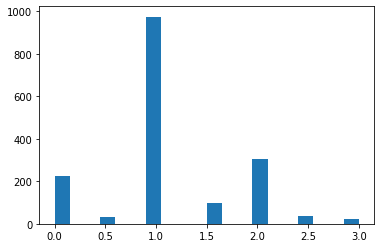

In [106]:
plt.hist(Y_reg.flatten(), range=(0, 3), bins=20)

In [111]:
((Y_reg.flatten() == 1) | (Y_reg.flatten() == -0.5) | (Y_reg.flatten() == 0.5)).sum() / (Y_reg == Y_reg).sum()

0.5950413223140496

(array([5.000e+00, 4.760e+02, 4.760e+02, 3.180e+02, 3.210e+02, 9.500e+02,
        1.107e+03, 9.510e+02, 9.480e+02, 1.580e+02, 0.000e+00, 1.580e+02,
        2.000e+00, 1.000e+00, 0.000e+00, 2.000e+00, 2.000e+00, 2.000e+00,
        0.000e+00, 1.000e+00]),
 array([0.  , 0.15, 0.3 , 0.45, 0.6 , 0.75, 0.9 , 1.05, 1.2 , 1.35, 1.5 ,
        1.65, 1.8 , 1.95, 2.1 , 2.25, 2.4 , 2.55, 2.7 , 2.85, 3.  ],
       dtype=float32),
 <BarContainer object of 20 artists>)

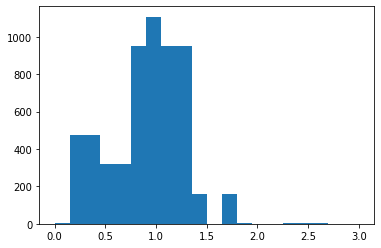

In [107]:
plt.hist(pred_reg.flatten(), range=(0, 3), bins=20)

In [155]:
labels = np.unique(Y[Y==Y])
counts = [(Y == label).sum() for label in labels]

<BarContainer object of 9 artists>

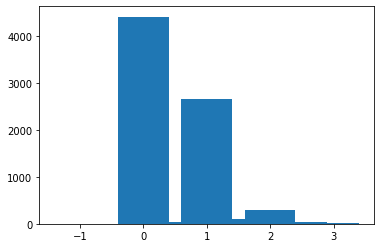

In [158]:
import matplotlib.pyplot as plt

plt.bar(labels, counts)

In [128]:
lengths = []
accuracies = []
var = []
max_len = max((Y_reg[:,i] == Y_reg[:,i]).sum() for i in range(Y_reg.shape[1]))
print(max_len)

for i in range(Y_reg.shape[1]):
    lengths.append((Y_reg[:,i] == Y_reg[:,i]).sum() / max_len)
    accuracies.append(reg_accuracy(Y_test[:,i], pred_reg[:,i], 0.5))
    var.append(Y_reg[:,i][Y_reg[:,i] == Y_reg[:,i]].var())

157


In [164]:
r2s = [r2_score(Y_test[:,i][Y_test[:,i]==Y_test[:,i]], pred_reg[:,i][Y_test[:,i]==Y_test[:,i]]) for i in range(Y_reg.shape[1])]

In [165]:
top = sorted([[a, i] for i, a in enumerate(r2s)], reverse=True)[:10]

In [166]:
top

[[0.02134542360956937, 13],
 [nan, 30],
 [0.0, 33],
 [0.0, 18],
 [-0.00010729284431021391, 26],
 [-0.0030526508472163982, 3],
 [-0.0030990302504303457, 7],
 [-0.004058564175028145, 28],
 [-0.004798303001930293, 27],
 [-0.015291561645840446, 31]]

In [160]:
top_lens = [(Y_reg[:, i] == Y_reg[:, i]).sum() for _, i in top]

In [151]:
names = [train_df.columns[i] for _, i in top]

In [152]:
names

['Облачные технологии',
 'Инжиниринг',
 'Диагностика и оценка качества образования',
 'Креативность и работа с неопределенностью',
 'Персонализация и непрерывное развитие',
 'проактивность, инновативность',
 'Управление ресурсными состояниями',
 'готовность к изменениям',
 'task1_text',
 'ИИ и интеллектуальный анализ данных',
 'Нейротехнологии',
 'Дизайн образования',
 'Работа с будущим',
 'Кросскультурность',
 'Автоматизированные и автоматические вычисления',
 'Самоорганизация и самоактуализация',
 'Лидерство',
 'Телекоммуникационные технологии',
 'Коммуникация',
 'task2_text',
 'Тиминг и командное взаимодействие',
 'email',
 'Технологии распределенных реестров (Blockchain)',
 'Беспроводная связь и интернет вещей',
 'Работа с большими данными',
 'Работа с данными',
 'Цифровой дизайн и моделирование']

<BarContainer object of 37 artists>

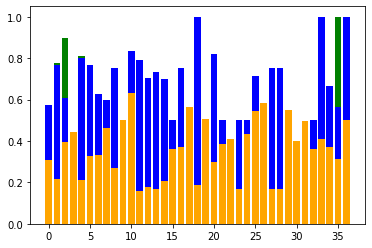

In [130]:
plt.bar(range(Y_reg.shape[1]), lengths, color='green')
plt.bar(range(Y_reg.shape[1]), accuracies, color='blue')
plt.bar(range(Y_reg.shape[1]), var, color='orange')

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan]

In [118]:
help(plt.plot)

Help on function plot in module matplotlib.pyplot:

plot(*args, scalex=True, scaley=True, data=None, **kwargs)
    Plot y versus x as lines and/or markers.
    
    Call signatures::
    
        plot([x], y, [fmt], *, data=None, **kwargs)
        plot([x], y, [fmt], [x2], y2, [fmt2], ..., **kwargs)
    
    The coordinates of the points or line nodes are given by *x*, *y*.
    
    The optional parameter *fmt* is a convenient way for defining basic
    formatting like color, marker and linestyle. It's a shortcut string
    notation described in the *Notes* section below.
    
    >>> plot(x, y)        # plot x and y using default line style and color
    >>> plot(x, y, 'bo')  # plot x and y using blue circle markers
    >>> plot(y)           # plot y using x as index array 0..N-1
    >>> plot(y, 'r+')     # ditto, but with red plusses
    
    You can use `.Line2D` properties as keyword arguments for more
    control on the appearance. Line properties and *fmt* can be mixed.
    The f